# Standard Layers

We will now see some examples of typical layers in DL.

Usually, layers have a batch axis, although frameworks and usually math take them implicitly.

A [typical neural network](https://dmol.pub/_images/nn.svg) that takes 128x128 images with 3 channels (RGB) and outputs a vector of 128 probabilities that codify the object seen by the NN (cat, vase, crane...).

## 1. Hyperparameters

We saw from the Full connected (FC)/Dense layer that we have to choose if we use bias, the activation, and the output shape. As we learn about more complex layers, there will be more choices. These choices begin to accumulate and in a neural network you may have billions of possible combinations of them. These choices about shape, activation, initialization, and other layer arguments are called hyperparameters. They are parameters in the sense that they can be tuned, but they are not trained on our data so we call them hyperparameters to distinguish them from the “regular” parameters like value of weights and biases in the layers. The name is inherited from Bayesian statistics.

### 1.1. Validation

The number of hyperparameters is high enough that overfitting can actually occur by choosing hyperparameters that minimize error on the test set. This is surprising because we don’t explicitly train hyperparameters. Nevertheless, you will find in your own work that if you use the test data extensively in hyperparameter tuning and for assessing overfitting of the regular training parameters, your performance will be overfit to the testing data. To combat this, we split our data three ways in deep learning:

1. Training data: used for trainable parameters.
2. Validation data: used to choose hyperparameters or measure overfitting of training data
3. Test data: data not used for anything except final reported error

To clean-up our nomenclature here, we use the word generalization error to refer to performance on a hypothetical infinite stream of unseen data. So regardless of if you split three-ways or use other approaches, generalization error means error on unseen data.

## 2. Common Layers

### 2.1. Convolutions

Convolutions are a layer typically used in image processing. Each convolutin layer has a grid $(H,W)$ that takes $H\times W$ pixels from the image and a set of filters $F$ that are trained to produce an output. Adding as well the channels we see that the layer has shape $(C, H, W, F)$.

Convolution Layers are **equivariant**, meaning that if the input (cat) is displaced in the image, the output is displaced as well. Another type of property is **invariance**, where the position of the input is irrelevant to the output.

Another important term is **padding**. If you want a grid of, say (32,32), but your input is (30,30), you can add 2 extra pixels to the sides and top and bottom parts, fill them with 0s, and obtain an image of (32,32).

### 2.2. Pooling

Convolutions are commonly paired with pooling layers because pooling also is translationally equivariant. If your goal is to produce a single number (regression) or class (classification) from an input image or sequence, you need to reduce the rank to 0, a scalar. After a convolution, you could use a reduction like average or maximum. It has been shown empirically that reducing the number of elements of your features more gradually is better. One way is through pooling. Pooling is similar to convolutions, in that you define a kernel shape (called window shape), but pooling has no trainable parameters. Instead, you run a window across your input grid and compute a reduction. Commonly an average or maximum is computed. For example, you might use three rounds of convolutions and pooling to take an image from $32\times 32$ down to a $4\times 4$. Read more about [pooling here](https://d2l.ai/chapter_convolutional-neural-networks/pooling.html).

### 2.3. Embedding

Another important type of input layers are embeddings. Embeddings convert integers into vectors. They are typically used to convert characters or words into numerical vectors. The characters or words are first converted into tokens separately as a pre-processing step and then the input to the embedding layer is the indices of the token. The indices are integer values that index into a dictionary of all possible tokens. It sounds more complex than it is. For example, we might tokenize characters in the alphabet. There are 26 tokens (letters) in the alphabet (dictionary of tokens) and we could convert the word “hello” into the indices [7,4,11,11,14], where 7 means the 7th letter of the alphabet.

After converting into indices, an embedding layer converts these indices into dense vectors of a chosen dimension. The rationale behind embeddings is to go from a large discrete space (e.g., all words in the English language) into a much smaller space of real numbers (e.g., vectors of size 5).

## 3. Example

At this point, we have enough common layers to try to build a neural network. We will combine these three layers to predict if a protein is soluble. Our [dataset](https://pubmed.ncbi.nlm.nih.gov/23926206/) consists of proteins known to be soluble or insoluble. As usual, the code below sets-up our imports.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib
# import dmol

Our task is binary classification. The data is split into two: positive and negative examples. We’ll need to rearrange a little into a normal dataset with labels and training/testing split. We also really really need to shuffle our data, so it doesn’t see all positives and then all negatives.

In [2]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/solubility.npz",
    "solubility.npz",
)
with np.load("solubility.npz") as r:
    pos_data, neg_data = r["positives"], r["negatives"]


# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
full_data = tf.data.Dataset.from_tensor_slices((features, labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
print(N, "examples")
split = int(0.1 * N)
test_data = full_data.take(split).batch(16)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

18453 examples


2022-07-06 15:28:49.482122: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-06 15:28:49.485529: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29524800 exceeds 10% of free system memory.


Before getting to modeling, let’s examine our data. The protein sequences have already been tokenized. There are 20 possible values at each position because there are 20 amino acids possible in proteins. Let’s see a soluble protein

In [3]:
pos_data.shape

(8785, 200)

Notice that integers/indices are used because our data is tokenized already. To make our data all be the same input shape, a special token (0) is inserted at the end indicating no amino acid is present. This needs to be treated carefully, because it should be zeroed throughout the network. Luckily this is built into Keras, so we do not need to worry about it.

This data is perfect for an embedding because we need to convert token indices to real vectors. Then we will use 1D convolutions to look for sequence patterns with pooling. We need to then make sure our final layer is a sigmoid, just like in Classification.

We begin with an embedding. We’ll use a 2-dimensional embedding, which gives us two channels for our sequence. We’ll just choose our kernel filter size for the 1D convolution to be 5 and we’ll use 16 filters. Beyond that, the rest of the network is about distilling gradually into a final class.

In [4]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# INFO FOR EMBEDDING

# input_dim: The size of the tokens on the input + 1. Since aminoacids
# are encoded from 1 to 20 we use input_dim = 21

# output_dim: The dimension that outputs of this layer.

# mask_zero: Indicates that 0 should be ignored because it has no meaning.

# input_length: The size of the vectors (tensors) that we are inputting to the layer


# now we move to convolutions and pooling
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           336       
                                                                 
 conv1d (Conv1D)             (None, 196, 16)           1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 16)            784       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 16)            7

In [5]:
model.compile("adam", loss="binary_crossentropy", metrics=["accuracy", "binary_accuracy"])
# Adam is an optimizer, alternative to SGD

result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

Epoch 1/10


2022-07-06 15:28:50.094881: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29524800 exceeds 10% of free system memory.
2022-07-06 15:28:50.134099: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29524800 exceeds 10% of free system memory.


 29/923 [..............................] - ETA: 5s - loss: 0.6926 - accuracy: 0.5022 - binary_accuracy: 0.5022

2022-07-06 15:28:51.277329: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18796992 exceeds 10% of free system memory.
2022-07-06 15:28:51.277385: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18796992 exceeds 10% of free system memory.


923/923 [==============================] - 7s 6ms/step - loss: 0.6900 - accuracy: 0.5372 - binary_accuracy: 0.5372 - val_loss: 0.6813 - val_accuracy: 0.5740 - val_binary_accuracy: 0.5740
Epoch 2/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6766 - accuracy: 0.5682 - binary_accuracy: 0.5682 - val_loss: 0.6731 - val_accuracy: 0.5751 - val_binary_accuracy: 0.5751
Epoch 3/10
923/923 [==============================] - 5s 6ms/step - loss: 0.6669 - accuracy: 0.5798 - binary_accuracy: 0.5798 - val_loss: 0.6675 - val_accuracy: 0.5799 - val_binary_accuracy: 0.5799
Epoch 4/10
923/923 [==============================] - 5s 6ms/step - loss: 0.6596 - accuracy: 0.5913 - binary_accuracy: 0.5913 - val_loss: 0.6786 - val_accuracy: 0.5621 - val_binary_accuracy: 0.5621
Epoch 5/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6503 - accuracy: 0.6101 - binary_accuracy: 0.6101 - val_loss: 0.6644 - val_accuracy: 0.5799 - val_binary_accuracy: 0.5799
Epoch 6/10
923/923 [=

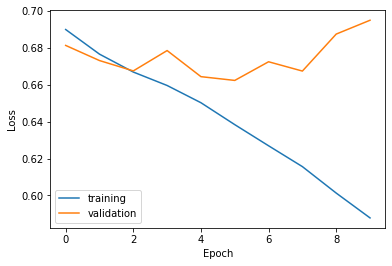

In [6]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

You can see this is a classic case of overfitting, with the validation data rising quickly as we improve our loss on the training data. Indeed, our model is quite expressive in its capability to fit the training data but it is incidentally fititng the noise. We have 61,000 trainable parameters and about 15,000 training examples, so this is not a surprise. However, we still able to learn a little bit – our accuracy is above 50%. This is actually a challenging dataset and the state-of-the art result is [77% accuracy](https://academic.oup.com/bioinformatics/article/34/15/2605/4938490?login=false). We need to expand our tools to include layers that can address overfitting.

## 4. Back propagation

At this stage, we should probably talk about back propagation and its connection to automatic gradient computation (autograds). This is how training “just works” when we take a gradient. This is actually a bit of a complicated topic, but it also nearly invisible to users of modern deep learning packages. Thus, I have chosen to not cover it in this book.

## 5. Regularization

As we saw in the ML chapters, regularization is a strategy that changes your training procedure (often by adding loss terms) to prevent overfitting. There is a nice argument for it in the bias-variance trade-off regarding model complexity, however this doesn’t seem to hold in practice. It is an empirical process that depends on many variables. Adding regularization if your model is underfit will usually reduce performance

### 5.1. Early Stopping

The most commonly used and simplest form of regularization is early stopping. Early stopping means monitoring the loss on your validation data and stopping training once it begins to rise. Normally, training is done until converged – meaning the loss stops decreasing. Early stopping tries to prevent overfitting by looking at the loss on unseen data (validation data) and stopping once that begins to rise. This is an example of regularization because the weights are limited to move a fixed distance from their initial value. Just like in L2 regularization, we’re squeezing our trainable weights. Early stopping can be a bit more complicated to implement in practice than it sounds, so check out how frameworks do it before trying to implement yourself (e.g., [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).

### 5.2. Weight

Weight regularization is the addition of terms to the loss that depend on the trainable weights in the solubility model example. These can be L2 or L1. You must choose the strength, which is expressed as a parameter (often denoted $\lambda$) that should be much less than 1. Typically values of 0.1 to 0.0001 are chosen. This may be broken into **kernel regularization**, which affects the multiplicative weights in a dense or convolution neural network, and **bias regularization**. Bias regularization is rarely seen in practice.

### 5.3. Activity

Activity regularization is the addition of terms to the loss that depend on the output from a layer. Activity regularization ultimately leads to minimizing weight magnitudes, but it makes the strength of that effect depend on the output from the layers. Weight regularization has the strongest effect on weights that have little effect on layer output, because they have no gradient if they have little effect on the output. In contrast, activity regularization has the strongest effect on weights that greatly affect layer output. Conceptually, weight regularization reduces weights that are unimportant but could harm generalization error if there is a shift in the type of features seen in testing. Activity regularization reduces weights that affect layer output and is more akin to early stopping by reducing how far those weights can move in training.

### 5.4. Batch Normalization

It is arguable if batch normalization is a regularization technique – there have been probably 10,000 papers on why it works. Batch normalization is a layer that is added to a neural network with trainable weights, but its trainable weights are not updated via gradient descent of the loss. Batch normalization has a layer equation of:
$$
f(X) =\frac{X-\bar{X}}{S}
$$
where $\bar{X}$ and $S$ are the sample mean and variance taken across the batch axis. This has the effect of “smoothing” out the magnitudes of values seen between batches. Remember that activations like ReLU depend on values being near 0 (since the nonlinear part is at $x=0$ and tanh has the most change in output around $x=0$, so you typically want your intermediate layer outputs to be around 0. At inference time you may not have batches or your batches may be a different size, so $\bar{X}$ and $S$ are set to the average across all batches seen in training data.

#### 5.4.1. Layer Normalization 

Batch normalization depends on there being a constant batch size. Some kinds of data, like text or a graphs, have different sizes and so the batch mean/variance can change significantly. Layer normalization avoids this problem by normalizing across the features (the non-zero axes) instead of the batch. This has a similar effect of making the layer output features behave well-centered at 0 but without having highly variable means/variances because of batch to batch variation. You’ll see these in graph neural networks and recurrent neural networks, wich both take variable sized inputs.

### 5.5. Dropout

The last regularization type is [dropout](https://dmol.pub/_images/drop_out.gif). Like batch normalization, dropout is typically viewed as a layer and has no trainable parameters. In dropout, we randomly zero-out specific elements of the input and then rescale the output so its average magnitude is unchanged. You can think of it like masking. There is a mask tensor $M$ which contains 1s and 0s and is multiplied by the input. It is called masking because we mask whatever was in the elements that were multiplied by 0. Then the output is multiplied by $|M|/\sum{M}$ where $|M|$ is the number of elements in $M$. Dropout forces your neural network to learn to use different features or “pathways” by zeroing out elements.

Weight regularization squeezes unused trainable weights through minimization. Dropout tries to force all trainable weights to be used by randomly negating weights. 

Dropout is more common than weight or activity regularization. Despite it appearing ad-hoc, it is effective. Note that dropout is only used during training, not for inference. You need to choose the dropout rate when using it, another hyperparameter. Usually, you will want to choose a rate of 0.05–0.35. 0.2 is common. Too small of a value – meaning you rarely do dropout – makes the effect too small to matter. Too large of a value – meaning you often dropout values – can prevent you from actually learning. As fewer nodes get updated with dropout, larger learnings rates with decay and a larger momentum can help with the model’s performance.

## 6. Residues

One last “layer” note to mention is residues. One of the classic problems in neural network training is vanishing gradients. If your neural network is deep and many features contribute to the label, you can have very small gradients during training that make it difficult to train. This is visible as underfitting. One way this can be addressed is through careful choice of optimization and learning rates. Another way is to add “residue” connections in the neural network. Residue connections are a fancy way of saying “adding” or “concatenating” later layers with early layers. The most common way to do this is:
$$
X^{i+1} = \sigma(W^i X^i + b^i) +X^i
$$
This is the usual equation for a dense neural network but we’ve added the previous layer output ($X^i$) to our output. Now when you take a gradient of earlier weights from layer $i-1$, they will appear through both the $\sigma(W^i X^i + b^i)$ term via the chain rule and the $X^i$ term.  term. This goes around the activation $\sigma$ and the effect of $W^i$.

Trainable weights can also be added to the Residues as 
$$
X^{i+1} = \sigma(W^i X^i + b^i) + W'^{i} X^{i}
$$
where $ W'^{i}$ is a new set of trainable parameters. 

We have seen that there are many hyperparametes for tuning and adjusting residue connections is one of the least effective things to adjust

## 7. Blocks

You can imagine that we might join a dense layer with dropout, batch normalization, and maybe a residue. When you group multiple layers together, this can be called a block for simplicity. For example, you might use the word “convolution block” to describe a sequential layers of convolution, pooling, and dropout.

## 8. Dropout Regularization Example

Now let’s try to add a few dropout layers to see if we can do better on our example above.

In [10]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# now we move to convolutions and pooling
# NOTE: Keras doesn't respect masking here
# I should switch to PyTorch.
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

# Here is the dropout
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 16)           336       
                                                                 
 conv1d_6 (Conv1D)           (None, 196, 16)           1296      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 49, 16)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 47, 16)            784       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 23, 16)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 21, 16)           

In [11]:
model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

Epoch 1/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6887 - accuracy: 0.5378 - val_loss: 0.6830 - val_accuracy: 0.5659
Epoch 2/10
923/923 [==============================] - 5s 6ms/step - loss: 0.6816 - accuracy: 0.5577 - val_loss: 0.6786 - val_accuracy: 0.5810
Epoch 3/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6747 - accuracy: 0.5615 - val_loss: 0.6799 - val_accuracy: 0.5783
Epoch 4/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6720 - accuracy: 0.5695 - val_loss: 0.6748 - val_accuracy: 0.5767
Epoch 5/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6678 - accuracy: 0.5791 - val_loss: 0.6691 - val_accuracy: 0.5930
Epoch 6/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6645 - accuracy: 0.5806 - val_loss: 0.6688 - val_accuracy: 0.6005
Epoch 7/10
923/923 [==============================] - 6s 7ms/step - loss: 0.6583 - accuracy: 0.5905 - val_loss: 0.6702 - val_accuracy: 0.5799
Epoch 

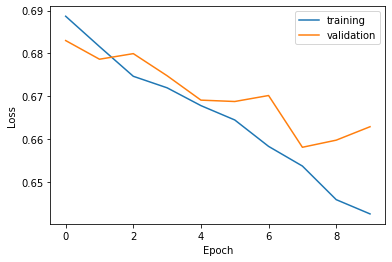

In [12]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Epoch 1/10
923/923 [==============================] - 7s 7ms/step - loss: 0.8101 - accuracy: 0.5225 - val_loss: 0.6919 - val_accuracy: 0.5388
Epoch 2/10
923/923 [==============================] - 6s 7ms/step - loss: 0.6924 - accuracy: 0.5229 - val_loss: 0.6910 - val_accuracy: 0.5388
Epoch 3/10
923/923 [==============================] - 6s 7ms/step - loss: 0.6922 - accuracy: 0.5229 - val_loss: 0.6911 - val_accuracy: 0.5388
Epoch 4/10
923/923 [==============================] - 5s 6ms/step - loss: 0.6922 - accuracy: 0.5229 - val_loss: 0.6915 - val_accuracy: 0.5388
Epoch 5/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6922 - accuracy: 0.5229 - val_loss: 0.6914 - val_accuracy: 0.5388
Epoch 6/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6922 - accuracy: 0.5229 - val_loss: 0.6913 - val_accuracy: 0.5388
Epoch 7/10
923/923 [==============================] - 6s 6ms/step - loss: 0.6922 - accuracy: 0.5229 - val_loss: 0.6911 - val_accuracy: 0.5388
Epoch 

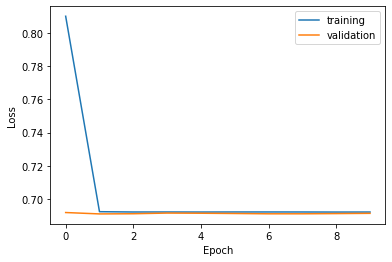

In [14]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# now we move to convolutions and pooling
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

# HERE IS THE REGULARIZATION:
model.add(tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"))
model.add(tf.keras.layers.Dense(64, activation="relu", kernel_regularizer="l2"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))


model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

L2 regularization is too strong it appears, preventing learning. You could go back and reduce the strength; here we’re just using the default which doesn’t look appropriate for our setting. Tuning hyperparameters like this is a favorite past time of neural network engineers and we could go on forever. We’ll stop here and leave it as an exercise for the reader to continue exploring hyperparameters.

Epoch 1/10
923/923 [==============================] - 7s 7ms/step - loss: 2.4232 - accuracy: 0.5204 - val_loss: 0.7632 - val_accuracy: 0.5388
Epoch 2/10
923/923 [==============================] - 6s 6ms/step - loss: 0.7640 - accuracy: 0.5229 - val_loss: 0.7636 - val_accuracy: 0.5388
Epoch 3/10
923/923 [==============================] - 6s 6ms/step - loss: 0.7640 - accuracy: 0.5229 - val_loss: 0.7628 - val_accuracy: 0.5388
Epoch 4/10
923/923 [==============================] - 7s 7ms/step - loss: 0.7640 - accuracy: 0.5229 - val_loss: 0.7627 - val_accuracy: 0.5388
Epoch 5/10
923/923 [==============================] - 5s 6ms/step - loss: 0.7640 - accuracy: 0.5229 - val_loss: 0.7633 - val_accuracy: 0.5388
Epoch 6/10
923/923 [==============================] - 5s 6ms/step - loss: 0.7639 - accuracy: 0.5229 - val_loss: 0.7634 - val_accuracy: 0.5388
Epoch 7/10
923/923 [==============================] - 6s 6ms/step - loss: 0.7639 - accuracy: 0.5229 - val_loss: 0.7632 - val_accuracy: 0.5388
Epoch 

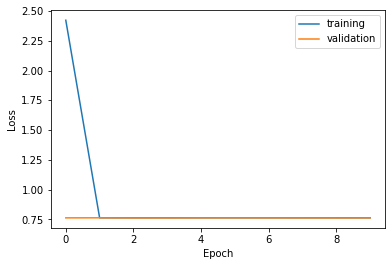

In [15]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# now we move to convolutions and pooling
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

# HERE IS THE REGULARIZATION we try with l1 now:
model.add(tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l1"))
model.add(tf.keras.layers.Dense(64, activation="relu", kernel_regularizer="l1"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))


model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

same problem

## 9. Activation Functions

Recall in Deep Learning Overview we mentioned that activation functions must be nonlinear and we often want them to have a region of input where the output value is zero. ReLU is the simplest example that satisfies these conditions - its output is zero for negative inputs and $f(x)=x$ for positive values. Choosing activation is another hyperparameter and choice that we make. ReLU started to dominat because of its runspeed.

Since 2019, this has been revisited because modern GPUs can run a variety of activation functions now quite quickly. Two commonly used modern activation functions are Gaussian Error Linear Units (GELU) and Swish. They can be made to deactivate the neuron at negative values. They seem to give better results because of their non-zero gradient at negative values; they can continue to respond to gradients while they are turned off. It is more common now to see Swish than ReLU in most newer networks and GELU is specifically seen in transformers

Swish:
$$
\sigma(x)=x·\text{sigmoid}(x)=x\frac{1}{1+e^x}
$$

GELU:
$$
\sigma(x)=x\Phi(x)=x·\frac{1}{2}\left[1+\text{erf}{\left(\frac{x-\mu}{\sigma\sqrt{2}}\right)}\right]
$$

## 10. How to create a NN

Designing and training neural networks is a complex task. The best approach is to always start simple and work your way up in complexity. Remember, you have to write correct code, create a competent model, and have clean data. If you start with a complex model it can be hard to discern if learning problems are due to bugs, the model, or the data. My advice is to always start with a pre-trained or simple baseline network from a previous paper. If you find yourself designing and training your own neural network, read through [Andrej Karpathy’s excellent guide](http://karpathy.github.io/2019/04/25/recipe/) on how to approach this task.

## 11. Summary

- Layers are created for specific tasks, and given the variety of layers, there are a vast number of permutations of layers in a deep neural network.
- Convolution layers are used for data defined on a regular grid (such as images). In a convolution, one defines the size of the trainable parameters through the kernel shape.
- An invariance is when the output from a neural network is insensitive to spatial changes in the input (translation, rotation, rearranging order)
- An equivariance is when the output from a neural network changes the same way as the input. See Input Data & Equivariances and Equivariant Neural Networks for concrete definitions.
- Convolution layers are often paired with pooling layers. A pooling layer behaves similarly to a convolution layer, except a reduction is computed and the output is a smaller shape (same rank) than the input.
- Embedding layers convert indices into vectors, and are typically used as pre-processing steps.
- Hyperparameters are choices regarding the shape of the layers, the activation function, initialization parameters, and other layer arguments. They can be tuned but are not trained on the data.
- Hyperparameters must be tuned by hand, as they can be continuous, categorical, or discrete variables, but there are algorithms being researched that tune hyperparameters.
- Tuning the hyperparameters can make training faster or require less training data.
- Using a validation data set can measure the overfitting of training data, and is used to help choose the hyperparameters.
- Regularization is an empirical technique used to change training procedures to prevent overfitting. There are five common types of regularization: early stopping, weight regularization, activity regularization, batch normalization, and dropout.
- Vanishing gradient problems can be addressed by adding “residue” connections, essentially adding later layers with early layers in the neural network.
